## Runing the Linear AA on the MNIST dataset


In [10]:

import torch
import numpy as np
from torchvision import datasets, transforms
from tqdm import tqdm
import matplotlib.pyplot as plt 
from scipy.spatial.distance import squareform, pdist
from src.methods.AALS import AALS 
from itertools import combinations
import os
import matplotlib.pyplot as plt
import numpy as np
import torch
import umap

/opt/anaconda3/envs/sae_env/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:

N_ARCHETYPES = 3
N_RUNS = 5

SAVE_DIR = 'results/MNIST_5runs'
os.makedirs(SAVE_DIR, exist_ok=True)

## Load MNIST data

In [16]:

# 1. Load and Preprocess MNIST (The "Binary" way)
print("Loading MNIST...")
transform = transforms.Compose([transforms.ToTensor(), transforms.ToTensor()])
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

data_all = mnist.data.numpy()
data_all = data_all / 255
data_all = (data_all * 2) - 1 # norm
labels = mnist.targets.numpy()

print("MNIST Loaded. Data shape:", data_all.shape)

Loading MNIST...
MNIST Loaded. Data shape: (60000, 28, 28)


In [17]:

# Pick single digit
digit = 4

# Select data for the specified digit
idx_digit = mnist.targets.numpy() == digit

# Create dataset for the selected digit
data_digit = data_all[idx_digit,]

# Reshape data to 2D array (samples x features)
data_digit = np.reshape(data_digit, (data_digit.shape[0], -1))

# Print shape of the digit-specific dataset
print(data_digit.shape)

# Added a transposoition to ensure final shape
X = torch.tensor(data_digit, dtype=torch.float64).transpose(0, 1)

(5842, 784)


(5842, 784) means we have 5842 samples of digit '4', each flattened to 784 features

## Gaussian Method

In [12]:
S_list = []
C_list = []
L_list = []  # <-- store the losses

for run in range(N_RUNS):
    print(f"Run {run+1}/{N_RUNS}")
    
    C_run, S_run, L_run, EV = AALS(X, N_ARCHETYPES)  # Your Linear AA function
    
    # Append to lists
    S_list.append(S_run.detach().cpu().numpy() if isinstance(S_run, torch.Tensor) else S_run)
    C_list.append(C_run.detach().cpu().numpy() if isinstance(C_run, torch.Tensor) else C_run)
    L_list.append(L_run)

# Save everything
torch.save({'C': C_list, 'S': S_list, 'L': L_list}, os.path.join(SAVE_DIR, 'mnist_gaussian_aa_results.pth'))


Run 1/5


KeyboardInterrupt: 

---

## Visualize the results

In [18]:
# Open the saved results to verify
results = torch.load('/Users/joaomata/Desktop/DTU/DeepLearning/ProjectDL/LinearAA/Python/results/MNIST_5runs/mnist_gaussian_aa_results.pth', weights_only=False)
print("Saved Results Keys:", results.keys())
print("Number of Runs Saved:", len(results['C']))

# Print shapes if the first run to verify
print("Shape of C in first run:", results['C'][0].shape)
print("Shape of S in first run:", results['S'][0].shape)
print("Length of Losses in first run:", len(results['L'][0]))

Saved Results Keys: dict_keys(['C', 'S', 'L'])
Number of Runs Saved: 5
Shape of C in first run: (5842, 3)
Shape of S in first run: (3, 5842)
Length of Losses in first run: 19


# Metric Formulas

In [19]:
def to_numpy(tensor):
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    return tensor

def preprocess(X):
    meanX = np.mean(X, axis=0)
    X_centered = X - meanX
    mSST = np.sum(np.mean(X_centered**2, axis=0))
    return X_centered, mSST

def calcMI(z1, z2):
    eps = 10e-16
    P = z1 @ z2.T
    PXY = P / P.sum()
    PXPY = np.outer(np.expand_dims(PXY.sum(1), axis=0), np.expand_dims(PXY.sum(0), axis=1))
    ind = np.nonzero(PXY > 0)
    MI = np.sum(PXY * np.log(eps + PXY / (eps + PXPY)))
    return MI

def calcNMI(z1, z2):
    NMI = (2 * calcMI(z1, z2)) / (calcMI(z1, z1) + calcMI(z2, z2))
    return NMI

def ArchetypeConsistency(XC1, XC2, mSST):
    D = squareform(pdist(np.hstack((XC1, XC2)).T, 'euclidean'))**2
    D = D[:XC1.shape[1], XC1.shape[1]:]
    # Greedy matching
    i = []
    j = []
    v = []
    K = XC1.shape[1]
    for k in range(K):
        min_index = np.unravel_index(np.argmin(D, axis=None), D.shape)
        i.append(min_index[0])
        j.append(min_index[1])
        v.append(D[i[-1], j[-1]])
        D[i[-1], :] = np.inf
        D[:, j[-1]] = np.inf
    consistency = 1 - np.mean(v) / mSST
    D2 = np.abs(np.corrcoef(np.hstack((XC1, XC2)).T))
    D2 = D2[:K, K:]
    ISI = 1 / (2 * K * (K - 1)) * (np.sum(D2 / np.max(D2, axis=1, keepdims=True) + D2 / np.max(D2, axis=0, keepdims=True)) - 2 * K)
    return consistency, ISI

In [20]:
from itertools import combinations

# Calculate metrics over the runs
C_matrices = [to_numpy(C) for C in results['C']]
print("C_matrices length:", len(C_matrices))
S_matrices = [to_numpy(S) for S in results['S']]
print("C_matrices length:", len(C_matrices))
X_centered, mSST = preprocess(to_numpy(X))

X_raw = to_numpy(X)

def compute_stability_metrics(S_list, C_list, X_raw, N_RUNS):
    """
    Compute pairwise stability metrics across runs.
    
    Returns:
        nmi_matrix, consistency_matrix, isi_matrix
    """
    X_centered, mSST_val = preprocess(X_raw)

    nmi_matrix = np.zeros((N_RUNS, N_RUNS))
    consistency_matrix = np.zeros((N_RUNS, N_RUNS))
    isi_matrix = np.zeros((N_RUNS, N_RUNS))

    for i, j in combinations(range(N_RUNS), 2):
        S_i, S_j = S_list[i], S_list[j]
        C_i, C_j = C_list[i], C_list[j]

        nmi_matrix[i, j] = calcNMI(S_i, S_j)
        consistency_matrix[i, j], isi_matrix[i, j] = ArchetypeConsistency(C_i, C_j, mSST_val)

    # Fill symmetric and diagonal
    nmi_matrix += nmi_matrix.T
    consistency_matrix += consistency_matrix.T
    isi_matrix += isi_matrix.T
    np.fill_diagonal(nmi_matrix, 1)
    np.fill_diagonal(consistency_matrix, 1)
    np.fill_diagonal(isi_matrix, 1)

    return nmi_matrix, consistency_matrix, isi_matrix

# --- Compute for Linear AA ---
nmi_linear, consistency_linear, isi_linear = compute_stability_metrics(S_matrices, C_matrices, X_raw, N_RUNS)

print("---")
print("Linear AA 5-run stability:")
print("---")
print("Mean NMI:", np.mean(nmi_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean Archetype Consistency:", np.mean(consistency_linear[np.triu_indices(N_RUNS, 1)]))
print("Mean ISI:", np.mean(isi_linear[np.triu_indices(N_RUNS, 1)]))


C_matrices length: 5
C_matrices length: 5
---
Linear AA 5-run stability:
---
Mean NMI: 0.999958838654645
Mean Archetype Consistency: 0.9999999491281948
Mean ISI: 0.0119896256123499


---

# Archetypal Analysis

In [21]:
# Select archetypes to visualize from the loaded results
C_linear = results['C'][0]
S_linear = results['S'][0]

print("C_linear shape:", C_linear.shape)
print("S_linear shape:", S_linear.shape)

C_linear shape: (5842, 3)
S_linear shape: (3, 5842)


### Visualizing the Archetypes

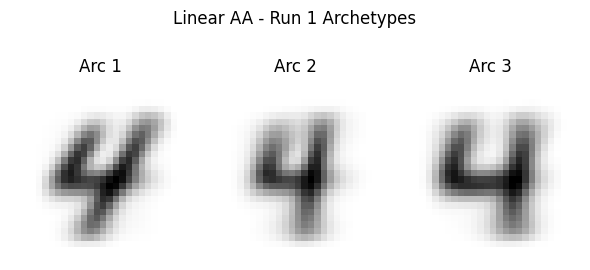

In [31]:
def to_numpy(tensor):
    """Convert tensor to numpy array if needed."""
    if isinstance(tensor, torch.Tensor):
        return tensor.detach().cpu().numpy()
    return tensor

def plot_archetypes(C, img_shape=(28,28), title="Archetypes"):
    # C is (features × archetypes)
    C = to_numpy(C)
    n_archetypes = C.shape[1]
    
    fig, axes = plt.subplots(1, n_archetypes, figsize=(2*n_archetypes, 3))
    for i in range(n_archetypes):
        img = C[:, i].reshape(img_shape)
        axes[i].imshow(img, cmap='gray_r')
        axes[i].axis('off')
        axes[i].set_title(f'Arc {i+1}')
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

# Transpose X_raw to (samples, features)
X_samples = X_raw.T 

# Reconstruct archetypes (features × archetypes)
C_recon = X_samples.T @ S_matrices[0].T  # (784, 3)

plot_archetypes(C_recon, img_shape=(28,28), title="Linear AA - Run 1 Archetypes")



/opt/anaconda3/envs/sae_env/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


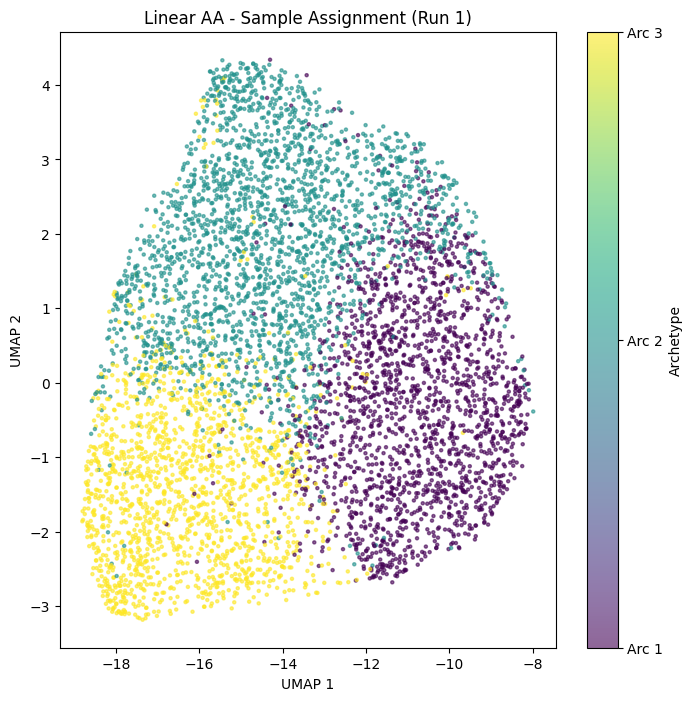

In [23]:

def plot_umap_assignment(X, S, title="Sample Assignment", s=5, alpha=0.6, cmap='viridis'):

    # Convert S to numpy if tensor
    S = to_numpy(S)
    X = to_numpy(X)

    # Step 1: compute dominant archetype for each sample
    dominant_arc = np.argmax(S, axis=0)  # shape: (N_samples,)

    # Step 2: reduce X to 2D using UMAP
    reducer = umap.UMAP(n_neighbors=30, min_dist=0.3, random_state=42)
    X_embedded = reducer.fit_transform(X)  # shape: (N_samples, 2)

    # Step 3: scatter plot colored by dominant archetype
    n_archetypes = S.shape[0]
    plt.figure(figsize=(8,8))
    scatter = plt.scatter(
        X_embedded[:,0],
        X_embedded[:,1],
        c=dominant_arc,
        cmap=cmap,
        s=s,
        alpha=alpha
    )
    plt.title(title)
    plt.xlabel("UMAP 1")
    plt.ylabel("UMAP 2")

    # Colorbar
    cbar = plt.colorbar(scatter, ticks=np.arange(n_archetypes))
    cbar.set_label("Archetype")
    cbar.set_ticklabels([f"Arc {i+1}" for i in range(n_archetypes)])

    plt.show()

# Linear AA: S_matrices[0] shape (k × N_samples)
plot_umap_assignment(X_samples, S_matrices[0], title="Linear AA - Sample Assignment (Run 1)")


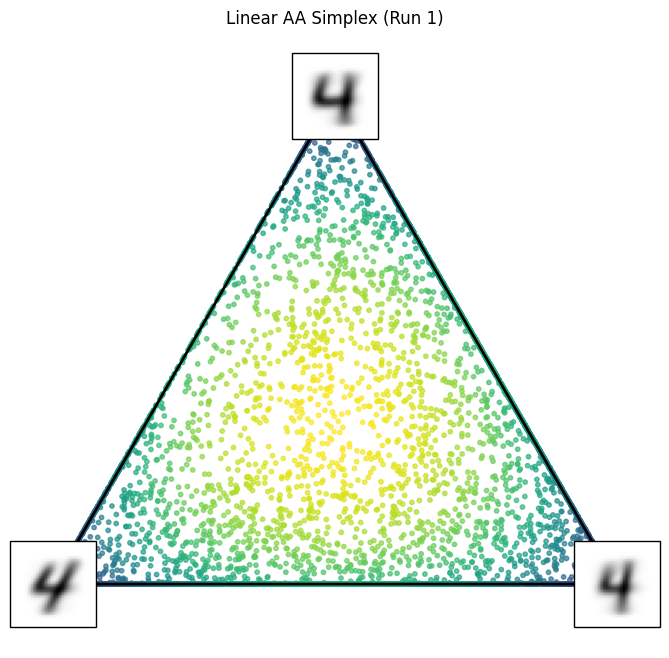

In [24]:
def plot_simplex(S, C=None, title="Simplex Plot", s=10, cmap='viridis', show_archetypes=True):
    S = np.array(S)
    k, N = S.shape
    if k != 3:
        raise ValueError("Simplex plot only works for k=3 archetypes")
    
    # Barycentric coordinates -> 2D triangle coordinates
    vertices = np.array([[0,0], [1,0], [0.5, np.sqrt(3)/2]])
    X_simplex = S.T @ vertices  # shape: (N_samples, 2)

    # Compute mixing strength (entropy)
    from scipy.stats import entropy
    mix_strength = np.array([entropy(S[:,i]) for i in range(N)])
    mix_strength /= np.log(3)  # normalize between 0 and 1

    # Plot samples
    plt.figure(figsize=(8,8))
    plt.scatter(X_simplex[:,0], X_simplex[:,1], c=mix_strength, cmap=cmap, s=s, alpha=0.7)
    
    # Draw triangle edges
    triangle = plt.Polygon(vertices, fill=False, edgecolor='black', linewidth=2)
    plt.gca().add_patch(triangle)
    
    # Plot archetypes at corners if requested
    if show_archetypes and C is not None:
        from matplotlib.offsetbox import OffsetImage, AnnotationBbox
        for i in range(3):
            img = C[:, i].reshape(28,28)  # adjust if different feature dims
            im_box = OffsetImage(img, zoom=2.0, cmap='gray_r')
            ab = AnnotationBbox(im_box, vertices[i], frameon=True, pad=0.3)
            plt.gca().add_artist(ab)

    plt.title(title)
    plt.axis('equal')
    plt.axis('off')
    plt.show()

# Linear AA
plot_simplex(S_matrices[0], C=C_recon, title="Linear AA Simplex (Run 1)")



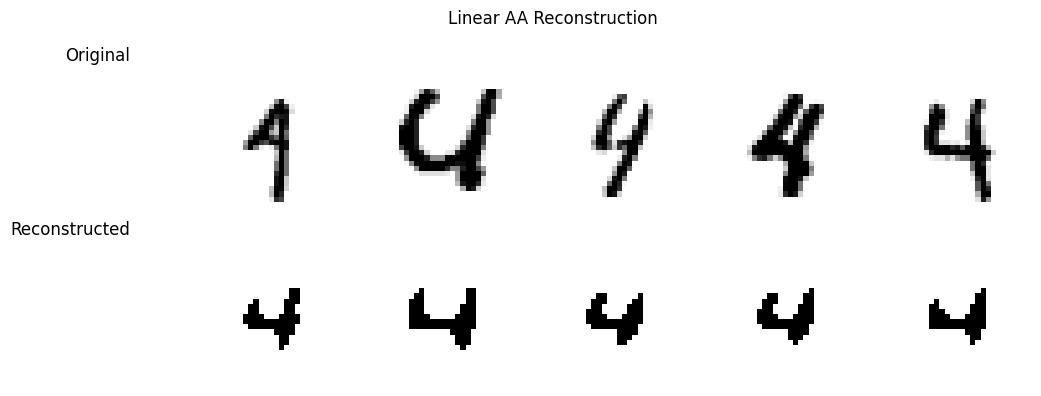

In [30]:
def plot_reconstruction_flat(X_orig, X_recon, n_samples=5, img_shape=(28,28), title="Reconstruction"):
    """
    Visualize random original samples and their reconstructions.

    X_orig: (samples, features)
    X_recon: (samples, features)
    """
    indices = np.random.choice(X_orig.shape[0], n_samples, replace=False)
    fig, axes = plt.subplots(2, n_samples, figsize=(2*n_samples, 4))

    for i, idx in enumerate(indices):
        # Original
        axes[0, i].imshow(X_orig[idx].reshape(img_shape), cmap='gray_r')
        axes[0, i].axis('off')
        if i == 0:
            axes[0, i].set_title("Original", x=-0.5, ha='right')

        # Reconstructed
        rec = np.clip(X_recon[idx].reshape(img_shape), X_orig.min(), X_orig.max())
        axes[1, i].imshow(rec, cmap='gray_r')
        axes[1, i].axis('off')
        if i == 0:
            axes[1, i].set_title("Reconstructed", x=-0.5, ha='right')

    plt.suptitle(title)
    plt.tight_layout()
    plt.show()


# Make sure X_raw is (samples, features)
X_samples = X_raw.T  # shape: (5842, 784)
C_recon = X_samples.T @ S_matrices[0].T  # (784, k)

# Reconstruct samples
X_rec = (C_recon @ S_matrices[0]).T 

plot_reconstruction_flat(X_samples, X_rec, n_samples=5, title="Linear AA Reconstruction")